In [97]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import json

In [83]:
# Define the endpoints
catalogus_url = 'https://waterwebservices.rijkswaterstaat.nl/METADATASERVICES_DBO/OphalenCatalogus'
waarnemingen_url = 'https://waterwebservices.rijkswaterstaat.nl/ONLINEWAARNEMINGENSERVICES_DBO/OphalenWaarnemingen'

In [84]:
    # Step 1: Retrieve the catalog of available data
catalogus_request = {
    "CatalogusFilter": {
        "Grootheden": True,
        "Eenheden": True,
        "Compartimenten": True
    }
}

In [85]:
catalogus_response = requests.post(catalogus_url, json=catalogus_request)
if catalogus_response.status_code != 200:
   print(f"Request failed with status code {catalogus_response.status_code}")
   print(f"Response content: {catalogus_response.text}")
catalogus_data = catalogus_response.json()

In [86]:
# Convert the locations data to a DataFrame
locaties_df = pd.DataFrame(catalogus_data['LocatieLijst'])

In [87]:
# Display the first few rows of the locations DataFrame
locaties_df.head()

,Locatie_MessageID,Coordinatenstelsel,X,Y,Naam,Code
0,9405,25831,650558.187857,5.821886e+06,Markermeer midden (zwaartepunt Markermeer),MARKMMDN
1,9889,25831,662953.888711,5.730335e+06,Hintham beneden,HHMO
2,9928,25831,705788.247439,5.671745e+06,Linne beneden,LINN
3,9943,25831,709204.680145,5.838074e+06,Meppelerdiep km 2.5,MEP25
4,9959,25831,711556.219876,5.803628e+06,Olst,OLST


In [88]:
# Step 2: Select a specific location and parameter
# For demonstration, we'll select the first location and the 'Waterhoogte' (water level) parameter
# Select the row where the 'Naam' column is equal to 'Borgharen Dorp'
selected_row = locaties_df[locaties_df['Naam'] == 'Borgharen Dorp']

# Get the 'Code', 'X', and 'Y' values from the selected row
if not selected_row.empty:
    selected_location = selected_row.iloc[0]['Code']
    selected_x = float(selected_row.iloc[0]['X'])
    selected_y = float(selected_row.iloc[0]['Y'])
    print(f"Selected Location Code: {selected_location}")
    print(f"X: {selected_x}, Y: {selected_y}")
else:
    print("Location 'Borgharen Dorp' not found in the catalog.")

selected_parameter = 'WATHTE'  # Code for water level


Selected Location Code: BORD
X: 689365.31984819, Y: 5639150.48421077


In [89]:
# Define the time period for data retrieval (e.g., last 7 days)
end_date = datetime.now()
start_date = end_date - timedelta(days=28)

# Format dates in ISO 8601 format
start_date_str = start_date.strftime('%Y-%m-%dT%H:%M:%S.000+01:00')
end_date_str = end_date.strftime('%Y-%m-%dT%H:%M:%S.000+01:00')

print(f"start: {start_date_str}, end: {end_date_str}")

start: 2025-01-22T16:03:50.000+01:00, end: 2025-02-19T16:03:50.000+01:00


In [90]:
# Step 3: Retrieve water level data for the selected location and time period
waarnemingen_request = {
    "Locatie": {"Code": selected_location, "X":selected_x, "Y": selected_y},
    "AquoPlusWaarnemingMetadata": {
        "AquoMetadata": {
            "Compartiment": {"Code": "OW"},  # OW stands for 'Oppervlaktewater' (surface water)
            "Grootheid": {"Code": selected_parameter}
        }
    },
    "Periode": {
        "Begindatumtijd": start_date_str,
        "Einddatumtijd": end_date_str
    }
}

In [91]:
waarnemingen_response = requests.post(waarnemingen_url, json=waarnemingen_request)
waarnemingen_data = waarnemingen_response.json()

In [94]:
waarnemingen_df = pd.DataFrame(waarnemingen_data)

# Save the 'waarnemingen_df' DataFrame to a JSON file
waarnemingen_df.to_json('water_level_data.json', orient='records', lines=True, force_ascii=False)

print("Water level data saved to 'water_level_data.json' successfully!")

# Display the first few rows of the observations DataFrame
print(f"\nWater Level Data for Location: {selected_location}")
waarnemingen_df.head()

Water level data saved to 'water_level_data.json' successfully!

Water Level Data for Location: BORD


,WaarnemingenLijst,Succesvol
0,"{'Locatie': {'Locatie_MessageID': 9874, 'Coord...",True


In [99]:
# Load the JSON data from the uploaded file
file_path = 'water_level_data.json'
with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

# Extract the measurement data
location_info = data['WaarnemingenLijst']['Locatie']
measurements = data['WaarnemingenLijst']['MetingenLijst']

# Convert the measurements to a DataFrame
df = pd.json_normalize(measurements)

# Extract relevant columns and clean up data
df['Tijdstip'] = pd.to_datetime(df['Tijdstip'])
df['Waarde_Numeriek'] = pd.to_numeric(df['Meetwaarde.Waarde_Numeriek'], errors='coerce')

# Drop unnecessary columns
columns_to_keep = ['Tijdstip', 'Waarde_Numeriek', 'WaarnemingMetadata.StatuswaardeLijst',
                   'WaarnemingMetadata.ReferentievlakLijst']
df = df[columns_to_keep]

# Handle invalid values (-999999999 as placeholder)
df.replace(-999999999, None, inplace=True)

# Sort data by timestamp
df.sort_values(by='Tijdstip', inplace=True)

# Display the cleaned data
df.head()  # Displays the first few rows of the cleaned data


,Tijdstip,Waarde_Numeriek,WaarnemingMetadata.StatuswaardeLijst,WaarnemingMetadata.ReferentievlakLijst
3031,2025-01-22 16:10:00+01:00,3979.0,[Ongecontroleerd],[NAP]
3032,2025-01-22 16:20:00+01:00,3978.0,[Ongecontroleerd],[NAP]
3033,2025-01-22 16:30:00+01:00,3978.0,[Ongecontroleerd],[NAP]
3034,2025-01-22 16:40:00+01:00,3976.0,[Ongecontroleerd],[NAP]
3035,2025-01-22 16:50:00+01:00,3975.0,[Ongecontroleerd],[NAP]


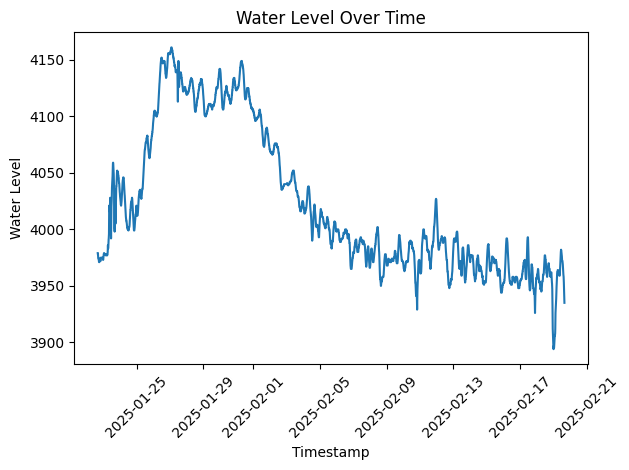

In [100]:
plt.plot(df['Tijdstip'], df['Waarde_Numeriek'])
plt.xlabel('Timestamp')
plt.ylabel('Water Level')
plt.title('Water Level Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
